# Imports

In [8]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import sys

stdout = sys.stdout

import tsaugmentation as tsag
import properscoring as ps


sys.stdout = stdout
sns.set()
plt.rcParams.update({'font.size': 22})

# Helper functions

In [9]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [10]:
def parse_file_name(file, dataset):
    flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
    idx_dataset_name = find(flatten_file_name, dataset)[0]
    sample = flatten_file_name[idx_dataset_name+1:-1][-1]
    version = flatten_file_name[idx_dataset_name+1:-1][-2]
    transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
    return sample, version, transformation

def compute_aggreated_results_dict(algorithm, dataset, path='../results_probabilistic', err_metric='mase'):
    results_dict={}
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            sample, version, transformation = parse_file_name(file, dataset)
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}
                
            results_dict_temp = copy.deepcopy(results_dict)
            results_dict_temp[transformation][version][sample] = pickle.load(handle)

            results_dict[transformation][version][sample][err_metric] = {}

            # We are getting the results for each group as lists and we want to store it 
            # as objects such as {'mase': {bottom_ind_1: value}, {bottom_ind_2: value}}
            for (k,v_) in results_dict_temp[transformation][version][sample][err_metric].items():
                # if it is the original versions we only want to get the individual results
                try: 
                    for i in range(len(v_)):
                        results_dict[transformation][version][sample][err_metric][f'{k}_{i}'] = v_[i]
                except TypeError:
                    # the group has individual results
                    pass
        handle.close()
    return results_dict

In [11]:
def compute_aggregated_results_df(results_dict):
    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all
    
    df = pd.DataFrame.from_dict({(i, j, k, l): results_dict[i][j][k][l]
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()
                           for l in results_dict[i][j][k].keys()}, orient='index')
    df = df.reset_index()
    df.rename(columns={'level_0':'transformation',
                       'level_1':'version',
                       'level_2':'sample',
                       'level_3':'error',}, inplace=True)
    df = df.melt(id_vars=['transformation', 'version', 'sample', 'error'],
           var_name = 'group',
           value_name = 'value')
    df = df.groupby(['group', 'version', 'sample', 'error']).mean().reset_index()
    df['group'] = df['group'].str.split('_').str[0]
    df['group'] = df['group'].str.lower()
    df.dropna(inplace=True)
    
    return df

In [12]:
def agg_res_bottom_series(results_dict):
    
    df = pd.DataFrame.from_dict({(i, j, k, l): results_dict[i][j][k][l]
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()
                           for l in results_dict[i][j][k].keys()}, orient='index')
    df = df.reset_index()
    df.rename(columns={'level_0':'transformation',
                       'level_1':'version',
                       'level_2':'sample',
                       'level_3':'error',}, inplace=True)
    df = df.melt(id_vars=['transformation', 'version', 'sample', 'error'],
           var_name = 'group',
           value_name = 'value')

    df_bottom = df.loc[df.group.str.contains('bottom')].groupby(['error', 'group']).mean().reset_index()
    df_bottom['order'] = df_bottom['group'].str.split('_').str[2].astype('int32')
    df_bottom['group'] = df_bottom['group'].str.split('_').str[0] + '_' + df_bottom['group'].str.split('_').str[2]
    return df_bottom.set_index('order').sort_values(by='order')

In [13]:
def get_output(dataset, algorithm, transf):
    path='../results_probabilistic'
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path and 'orig' in path and transf in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            e = pickle.load(handle)
            handle.close()
    return e

In [14]:
def plot_compare_err_metric(err='mase', dataset='prison'):
    dict_gpf = compute_aggreated_results_dict(algorithm='gpf', dataset=dataset, err_metric=err)
    df_gpf_bottom = agg_res_bottom_series(dict_gpf)
    dict_mint = compute_aggreated_results_dict(algorithm='mint', dataset=dataset, err_metric=err)
    df_mint_bottom = agg_res_bottom_series(dict_mint)
    dict_deepar = compute_aggreated_results_dict(algorithm='deepar', dataset=dataset, err_metric=err)
    df_deepar_bottom = agg_res_bottom_series(dict_deepar)
    _, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax = ax.ravel()
    sns.barplot(x="value", y="group", data=df_gpf_bottom, color='blue', ax=ax[0])
    ax[0].set_title('gpf')
    sns.barplot(x="value", y="group", data=df_mint_bottom, color='darkorange', ax=ax[1])
    ax[1].set_title('mint')
    sns.barplot(x="value", y="group", data=df_deepar_bottom, color='green', ax=ax[2])
    ax[2].set_title('deepar');

In [15]:
def calculate_agg_results_all_datasets(datasets: list, err: str) -> list[pd.DataFrame]:
    """Calculate aggregated results for all datasets with the purpose of plotting
    
    Parameters
    ----------
    datasets : list of datasets
    err : string with the error to be calculated

    Returns
    ----------
        list[pd.Dataframe]: - returns list of dataframes for each dataset to be plotted individually

    """
    df_orig_list = []
    for d in datasets:
        dict_gpf = compute_aggreated_results_dict(algorithm='gpf', dataset=d, err_metric=err)
        df_gpf = compute_aggregated_results_df(dict_gpf)
        dict_mint = compute_aggreated_results_dict(algorithm='mint', dataset=d, err_metric=err)
        df_mint = compute_aggregated_results_df(dict_mint)
        dict_deepar = compute_aggreated_results_dict(algorithm='deepar', dataset=d, err_metric=err)
        df_deepar = compute_aggregated_results_df(dict_deepar)
        df_gpf['algorithm']='gpf'
        df_mint['algorithm']='mint'
        df_deepar['algorithm']='deepar'
        df = pd.concat([df_gpf, df_mint, df_deepar])
        df_orig = df[(df['version']=='orig')&(df['error']==err)].reset_index().drop(['index'], axis=1)

        # sort values by algorithm to plot gpf -> mint -> deepar
        sorter = ['gpf', 'mint', 'deepar']
        df_orig = df_orig.sort_values(by='group')
        df_orig.algorithm = df_orig.algorithm.astype("category")
        df_orig.algorithm.cat.set_categories(sorter, inplace=True)
        df_orig_list.append(df_orig)
    return df_orig_list

# Calculation of CRPS - example for a single series

In [16]:
data = tsag.preprocessing.PreprocessDatasets('prison').apply_preprocess()

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [17]:
true = data['predict']['data'].reshape((32, 48)).T

### GPF

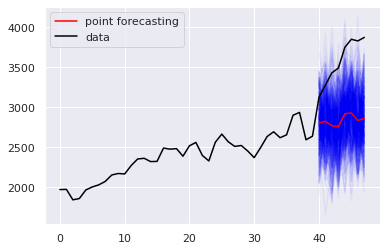

In [18]:
e = get_output('prison', 'gpf', 'jitter')
series = 6
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [19]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

563.4301369098712

### MinT

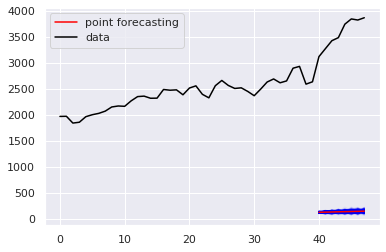

In [20]:
e = get_output('prison', 'mint', 'jitter')
series = 6
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [21]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

3431.0651070806794

### DeepAR

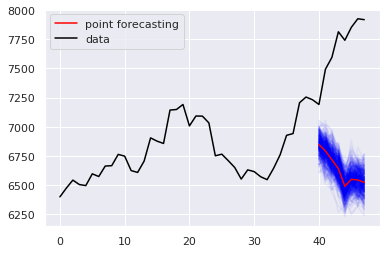

In [22]:
e = get_output('prison', 'deepar', 'jitter')
series = 7
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

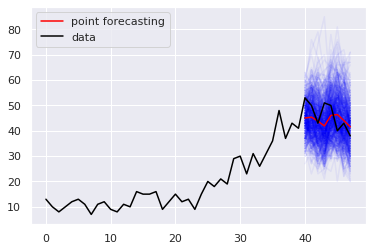

In [23]:
e = get_output('prison', 'deepar', 'jitter')
series = 8
plt.plot(np.arange(40, 48), e['predictions']['samples']['bottom'][-8:, series, :], alpha=0.05, color='blue')
plt.plot(np.arange(40, 48), e['predictions']['points']['bottom'][:, series], alpha=1, color='red', label='point forecasting')
plt.plot(true[:,series], color='black', label='data')
plt.legend();

In [24]:
ps.crps_ensemble(true[-8:, series], e['predictions']['samples']['bottom'][-8:, series, :]).mean()

3.392143

# Calculation of MASE for each algorithm

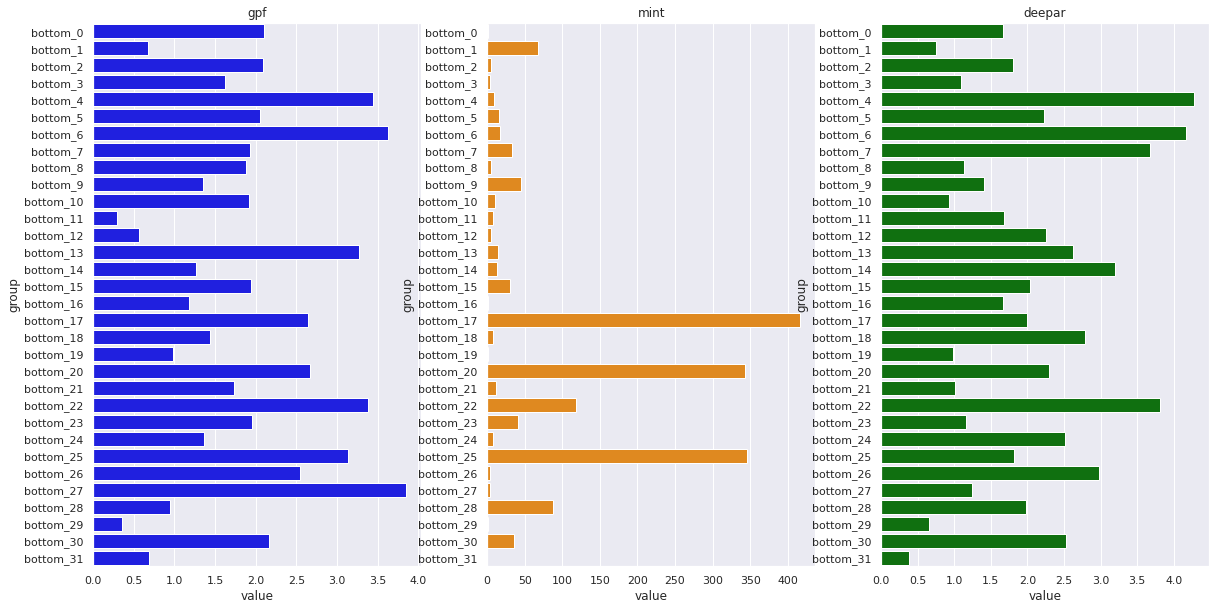

In [25]:
plot_compare_err_metric('mase', 'prison')

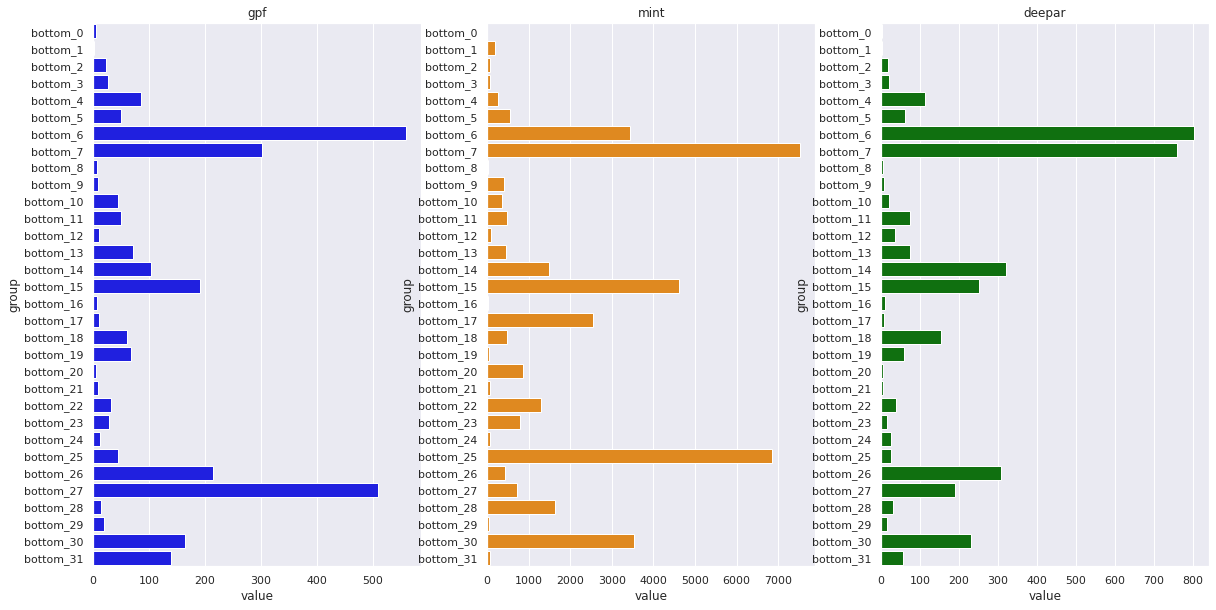

In [26]:
plot_compare_err_metric('CRPS')

# Calculating aggregate results for all algorithms

In [27]:
df_orig_list = calculate_agg_results_all_datasets(['prison'], 'CRPS')

In [28]:
_, ax = plt.subplots(len(datasets), 1, figsize=(20, 10*len(datasets)))
fg = sns.boxplot(x='group', 
                 y='value',
                 hue='algorithm',
                 data=df_orig_list[i],
                 ax=ax)
ax.set_title(datasets, fontsize=20)
plt.legend()
plt.show()

NameError: name 'datasets' is not defined